In [1]:
import numpy as np
import seaborn as sns
import torch

import umap
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
from torch_geometric.utils import k_hop_subgraph,to_networkx,from_networkx
import matplotlib

import utils
import plots
from model_AE import reduction_AE
from model_GAT import Encoder,SenGAE,train_GAT
from model_Sencell import Sencell

import logging
import os
import argparse


parser = argparse.ArgumentParser(description='Main program for sencells')

parser.add_argument('--output_dir', type=str, default='./outputs', help='')
parser.add_argument('--exp_name', type=str, default='', help='')

args = parser.parse_args(args=[])

args.exp_name='disease'

if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)

logging.basicConfig(format='%(asctime)s.%(msecs)03d [%(levelname)s] [%(filename)s:%(lineno)d] %(message)s',
                    datefmt='# %Y-%m-%d %H:%M:%S')

logging.getLogger().setLevel(logging.DEBUG)
logger = logging.getLogger()

# Part 1: load and process data
# cell_cluster_arr在画umap的时候用
adata,cluster_cell_ls,cell_cluster_arr,celltype_names=utils.load_data_disease()
# plots.umapPlot(adata.obsm['X_umap'],clusters=cell_cluster_arr,labels=celltype_names)

new_data,markers_index,\
sen_gene_ls,nonsen_gene_ls,gene_names=utils.process_data(adata,cluster_cell_ls,cell_cluster_arr)

print(f'cell num: {new_data.shape[0]}, gene num: {new_data.shape[1]}')

gene_cell=new_data.X.toarray().T
graph_nx=utils.build_graph_nx(gene_cell,cell_cluster_arr,sen_gene_ls,nonsen_gene_ls,gene_names)
logger.info("Part 1, data loading and processing end!")

# Part 2: generate init embedding
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:',device)
args.device=device

retrain=False
if retrain:
    gene_embed,cell_embed=reduction_AE(gene_cell,device)
    print(gene_embed.shape,cell_embed.shape)
    torch.save(gene_embed,os.path.join(args.output_dir,f'{args.exp_name}_gene.emb'))
    torch.save(cell_embed,os.path.join(args.output_dir,f'{args.exp_name}_cell.emb'))
else:
    gene_embed=torch.load(os.path.join(args.output_dir,f'{args.exp_name}_gene.emb'))
    cell_embed=torch.load(os.path.join(args.output_dir,f'{args.exp_name}_cell.emb'))

graph_nx=utils.add_nx_embedding(graph_nx,gene_embed,cell_embed)
graph_pyg=utils.build_graph_pyg(gene_cell,gene_embed,cell_embed)
logger.info("Part 2, AE end!")

# Part 3: train GAT
# graph_pyg=graph_pyg.to('cpu')
args.gene_num=gene_cell.shape[0]
args.cell_num=gene_cell.shape[1]



GAT_model=train_GAT(graph_nx,graph_pyg,args,retrain=False,resampling=False)
logger.info("Part 3, training GAT end!")



from sampling import identify_sencell_marker_graph
from sampling import sub_sampling_by_random
from model_Sencell import cell_optim,update_cell_embeddings,old_cell_optim

from sampling import identify_sengene_then_sencell


all_gene_ls=[]

list_sencell_cover=[]
list_sengene_cover=[]

def get_sencell_cover(old_sencell_dict,sencell_dict):
    set1=set(list(old_sencell_dict.keys()))
    set2=set(list(sencell_dict.keys()))
    set3=set1.intersection(set2)
    print('sencell cover:',len(set3)/len(set2))
    
    return len(set3)/len(set2)

def get_sengene_cover(old_sengene_ls,sengene_ls):
    set1=set(old_sengene_ls)
    set2=set(sengene_ls)
    set3=set1.intersection(set2)
    print('sengene cover:',len(set3)/len(set2))
    
    return len(set3)/len(set2)


# 2022-11-30 20:22:25.241 [DEBUG] [attrs.py:77] Creating converter from 3 to 5


cluster 数量： 14
celltype names: ['0', '1', '2', '3', '5', 'Epithelial cells', '7', '8', '10', 'Pericytes', 'Fibroblasts-Pericytes', '14', '9', 'Endothelial cells']
---------------------  -----
0                      10712
1                       7273
2                       5435
3                       3923
5                       2695
Epithelial cells        2385
7                       1630
8                       1607
10                       900
Pericytes                571
Fibroblasts-Pericytes    466
14                       361
9                        263
Endothelial cells        186
---------------------  -----
各marker list所包含的gene数：
  Markers1    Markers2    Markers3    Markers4
----------  ----------  ----------  ----------
       126          78         145          84
total marker genes:  380


/users/PCON0022/haocheng/.conda/envs/deepmaps_env/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


highly_genes num:  2000
After highly genes dropped duplicate:  1924
Total gene num: 2286
cell num: 38407, gene num: 2286
The number of edges: 3688551


# 2022-11-30 20:22:46.792 [INFO] [3306991342.py:53] Part 1, data loading and processing end!


device: cuda:0
the number of edges: 3688551
edge index:  torch.Size([2, 3688551])
node feature:  torch.Size([40693, 128])
Pyg graph: Data(x=[40693, 128], edge_index=[2, 7377102], y=[40693])


# 2022-11-30 20:22:52.866 [INFO] [3306991342.py:72] Part 2, AE end!
# 2022-11-30 20:22:52.875 [INFO] [3306991342.py:82] Part 3, training GAT end!


graph.is_directed(): False


In [2]:
cellmodel=Sencell().to(device)
optimizer = torch.optim.Adam(cellmodel.parameters(), lr=0.001, 
                                weight_decay=1e-3)
all_marker_index=sen_gene_ls
    
iteration_results=[]
for iteration in range(5):
    logger.info(f"iteration: {iteration}")
    sampled_graph,sencell_dict,nonsencell_dict,cell_clusters,big_graph_index_dict=sub_sampling_by_random(graph_nx,
                                                            sen_gene_ls,
                                                            nonsen_gene_ls,
                                                            GAT_model,
                                                            args,
                                                            all_marker_index,
                                                            n_gene=len(all_marker_index),                                                        
                                                            gene_rate=0.3,cell_rate=0.5,
                                                            debug=False)
    old_sengene_indexs=all_marker_index
    for epoch in range(10):
        logger.info(f"epoch: {epoch}")
        old_sencell_dict=sencell_dict
        cellmodel,sencell_dict,nonsencell_dict=cell_optim(cellmodel,optimizer,
                                                          sencell_dict,nonsencell_dict,args,
                                                         train=False)
        sampled_graph=update_cell_embeddings(sampled_graph,sencell_dict,nonsencell_dict)
        sencell_dict,nonsencell_dict, \
        sen_gene_indexs,nonsen_gene_indexs=identify_sengene_then_sencell(sampled_graph,GAT_model,
                                                                      sencell_dict,nonsencell_dict,
                                                                      cell_clusters,
                                                                      big_graph_index_dict,
                                                                      len(all_marker_index),args)
        break
    break

# 2022-11-30 20:22:52.888 [INFO] [1031332177.py:8] iteration: 0


Start sampling subgraph randomly ...
    Sengene num: 362, Nonsengen num: 362
subgraph total node num: (39131,)
After sampling, gene num:  tensor(724)


# 2022-11-30 20:39:18.352 [INFO] [1031332177.py:20] epoch: 0


obj saved ./outputs/disease_cell_score_dict_test
    Sencell num: 200, Nonsencell num: 2000
rechoice sengene num: 362 rechoice nonsengene num: 362
obj saved ./outputs/disease_cell_score_dict_test
    Sencell num: 200, Nonsencell num: 2000


In [3]:
cluster_cell_dict={}
cell_cluster_ls=[v[1] for k,v in sencell_dict.items()]
cell_index_ls=[v[3]-args.gene_num for k,v in sencell_dict.items()]
for cluster,index in zip(cell_cluster_ls,cell_index_ls):
    if cluster in cluster_cell_dict:
        cluster_cell_dict[cluster].append(index)
    else:
        cluster_cell_dict[cluster]=[index]
        
cluster_cell_dict

{0: [18233,
  11808,
  13949,
  15620,
  11181,
  13040,
  23969,
  15467,
  15532,
  23874,
  11778,
  20949,
  23572,
  15796,
  7975,
  11483,
  12370,
  1949,
  16291,
  11611,
  15331,
  11232,
  9843,
  24897,
  7259,
  9895,
  13637,
  8693,
  6198,
  8172,
  33476,
  8000,
  38073,
  7101,
  6102,
  36263],
 12: [4152, 28932],
 2: [27929,
  16579,
  23954,
  12839,
  102,
  15879,
  17112,
  25449,
  15961,
  15170,
  10283,
  24678,
  13027,
  29116,
  277,
  36436,
  13696,
  36706,
  16434],
 10: [4835,
  8636,
  25837,
  24244,
  21817,
  4035,
  16571,
  22571,
  11292,
  19363,
  15074,
  13914,
  13018],
 5: [29095, 18231, 7104, 8729, 1126, 9980, 12545],
 3: [9724,
  10704,
  11192,
  10835,
  9888,
  3005,
  3678,
  7752,
  9615,
  17009,
  12785,
  5684,
  7589,
  7122,
  28907,
  31504,
  13755,
  26390,
  19689,
  14152,
  13610,
  11362,
  15924,
  2251,
  28491,
  8039,
  16131,
  17087,
  10255,
  24362,
  8021,
  11744,
  7567,
  9055,
  3907,
  10390,
  18427,
 

In [4]:
# cluster内部不取交集
def get_celltype_specific_genes(cluster_cell_dict,graph_nx,sen_gene_indexs,gene_names,args):
    # {cluster:gene names}
    outputs_dict={}
    total_genes=set()
    for key,value in cluster_cell_dict.items():
        print(f'cluster: {key}')
        gene_ls=[]
        for cell_index in value:
            gene_ls=gene_ls+[i for i in graph_nx.neighbors(cell_index+args.gene_num)]
        results=set(gene_ls)
        results=results.intersection(set(sen_gene_indexs))
        results=[gene_names[i] for i in results]
        total_genes.update(results)
        outputs_dict[key]=sorted(results)
    return outputs_dict,total_genes

outputs_dict,total_genes=get_celltype_specific_genes(cluster_cell_dict,graph_nx,sen_gene_indexs,gene_names,args)

cluster: 0
cluster: 12
cluster: 2
cluster: 10
cluster: 5
cluster: 3
cluster: 1
cluster: 13
cluster: 9
cluster: 7


['AXL', 'CXCL3', 'NEK6', 'SPP1', 'ZAP70', 'BATF', 'CCL5', 'IL32', 'EREG', 'IL1R2', 'THBS1', 'AGR3', 'ALDH1A3', 'ALOX15B', 'ANG', 'BEX3', 'BMP2', 'C4BPA', 'CCL16', 'CDKN2AIP', 'CKB', 'CLIC3', 'DMBT1', 'DPY30', 'ECRG4', 'EEF1E1', 'EFCAB1', 'EHF', 'F3', 'FAM92B', 'FMO3', 'GDF15', 'LRRIQ1', 'MAPK9', 'MAST1', 'NUAK2', 'PAK4', 'PALMD', 'PAWR', 'PDZD2', 'PFKFB2', 'PIGR', 'RBP2', 'SFTPA2', 'SFTPB', 'SH2D3A', 'SLPI', 'SORBS2', 'SOX2', 'SPX', 'SRF', 'STEAP4', 'TNC', 'TPPP3', 'ULK3', 'ZKSCAN3', 'ZNF277', 'AGR3', 'ALOX15B', 'BMPR1A', 'C4BPA', 'CKB', 'CXCL1', 'DMBT1', 'ECRG4', 'EFCAB1', 'EHF', 'FAM92B', 'GDF15', 'ID4', 'KITLG', 'LRRIQ1', 'MAPK10', 'PDZD2', 'PIGR', 'SCGB3A1', 'SFN', 'SFTPA2', 'SFTPB', 'SLPI', 'SOX2', 'STEAP4', 'TPPP3', 'AC103591.3', 'IGLC2', 'ACKR1', 'ACVR1B', 'BTNL9', 'CA4', 'CAVIN2', 'CCL16', 'CDKN1C', 'CMTM8', 'CNTNAP3B', 'DAAM2', 'EDN1', 'EDNRB', 'EGFL7', 'ESM1', 'FCN3', 'FZD4', 'IGF1R', 'IGFBP1', 'IGFBP3', 'IL1RL1', 'IL6', 'ITGA2', 'JCAD', 'MAPKAPK5', 'NOS2', 'PAK4', 'PML', 'PO

# 2022-11-30 21:20:19.093 [DEBUG] [colorbar.py:620] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b7ccc88dca0>
# 2022-11-30 21:20:19.094 [DEBUG] [colorbar.py:665] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b7ccc88dca0> on colorbar
# 2022-11-30 21:20:19.095 [DEBUG] [colorbar.py:794] Setting pcolormesh


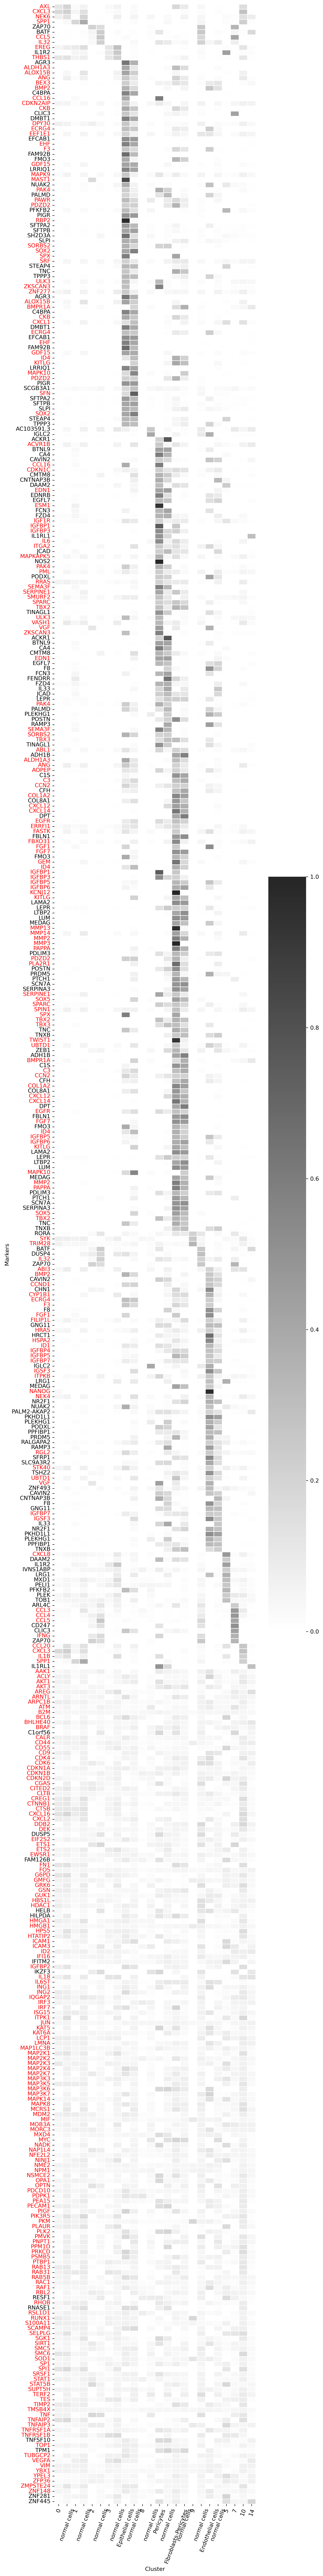

In [13]:
def get_matrix(rows,cols,outputs_dict):
    matrix=np.zeros((len(rows),len(cols)))

    for col_index in range(len(cols)):
        cluster=cols[col_index]
        genes=outputs_dict[cluster]
        for gene in genes:
            row_index=rows.index(gene)
            matrix[row_index][col_index]=1
            
    return matrix

def get_matrix_exp(rows,cols,outputs_dict):
    # cluster_cell_ls
    # gene_cell
    # gene_names
    # heatmap显示表达量
    matrix=np.zeros((len(rows),len(cols)))

    for col_index in range(len(cols)):
        cluster=cols[col_index]
        for gene in rows:
            row_index=rows.index(gene)
            cells=cluster_cell_dict[cluster]
            exp=sum(gene_cell[gene_names.index(gene)][cells])/len(cells)
            matrix[row_index][col_index]=exp
    for i,line in enumerate(matrix):
        matrix[i]=matrix[i]/sum(matrix[i])
    return matrix


def get_matrix_new(rows,cols,outputs_dict):
    results=[]
    cols_names=[]
    for col_index in range(len(cols)):
        cluster=cols[col_index]
        cols_names.append(celltype_names[cluster])
        cols_names.append('normal cells')
        all_cells=cluster_cell_ls[cluster]
        sencells=cluster_cell_dict[cluster]
        nonsencells=list(set(all_cells)-set(sencells))
        
        sencell_col=[]
        nonsencell_col=[]
        
        for gene in rows:
            exp=sum(gene_cell[gene_names.index(gene)][sencells])/len(sencells)
            sencell_col.append(exp)
            exp=sum(gene_cell[gene_names.index(gene)][nonsencells])/len(nonsencells)
            nonsencell_col.append(exp)
    
        results.append(sencell_col)
        results.append(nonsencell_col)
    
    for cluster in range(len(celltype_names)):
        if cluster not in cols:
            normal_cells=cluster_cell_ls[cluster]
            cols_names.append(celltype_names[cluster])
            exp_ls=[]
            for gene in rows:
                exp=sum(gene_cell[gene_names.index(gene)][normal_cells])/len(normal_cells)
                exp_ls.append(exp)
            results.append(exp_ls)
    
    results=np.array(results).T
    for i,line in enumerate(results):
        results[i]=results[i]/sum(results[i])
    return results,cols_names

def change_row_order(rows,cols,outputs_dict):
    # 按表达数量从少到多排序
    matrix=get_matrix(rows,cols,outputs_dict)

    results=[]
    for i,lines in enumerate(matrix):
        results.append([i,sum(lines)])
    results=sorted(results, key=lambda item: item[1])
    indexs=[i[0] for i in results]
    rows=np.array(sorted(list(total_genes)))[indexs]
    rows=list(rows)
    return rows

def change_row_order_by_list(rows,head_list):
    for i in head_list:
        if i in rows:
            rows.remove(i)
    rows=head_list+rows
    
    return rows


def find_celltype_specific_genes(rows,matrix):
    results={}
    for i,line in enumerate(matrix):
        max_index=np.argmax(line)
        if max_index in results:
            results[max_index].append(rows[i])
        else:
            results[max_index]=[rows[i]]
    
    outputs=[]
    for i in range(matrix.shape[1]):
        if i in results:
            outputs=outputs+results[i]

    return outputs


def find_celltype_specific_genes1(rows,matrix):
    results=[]
    for col in range(matrix.shape[1]):
        ct_specific=[]
        for i,line in enumerate(matrix):
            if line[col]>=0.2:
                ct_specific.append(rows[i])
        results=results+ct_specific
    return results


rows=sorted(list(total_genes))
cols=sorted(list(outputs_dict.keys()))

matrix,cols_names=get_matrix_new(rows,cols,outputs_dict)
head_list=find_celltype_specific_genes1(rows,matrix)
print(head_list)
rows=change_row_order_by_list(rows,head_list)
matrix,cols_names=get_matrix_new(rows,cols,outputs_dict)

plt.figure(figsize=(8,80),dpi=300)

ax=sns.heatmap(matrix, cmap=sns.dark_palette("white", reverse=True, as_cmap=True),xticklabels=cols_names,yticklabels=rows,linewidth=.5)
plt.ylabel('Markers')
plt.xlabel("Cluster")
# plt.get_ticklines()
for tick in ax.get_xticklabels():
    tick.set_rotation(70)

indexs=[]
sen_gene_names=[gene_names[i] for i in sen_gene_ls]
for i,j in enumerate(rows):
    if j in sen_gene_names:
        indexs.append(i)
for i in indexs:
    ax.get_yticklabels()[i].set_color("red") 

# 2022-11-30 21:13:50.851 [DEBUG] [colorbar.py:620] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b7ccb4e3ac0>
# 2022-11-30 21:13:50.853 [DEBUG] [colorbar.py:665] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b7ccb4e3ac0> on colorbar
# 2022-11-30 21:13:50.854 [DEBUG] [colorbar.py:794] Setting pcolormesh


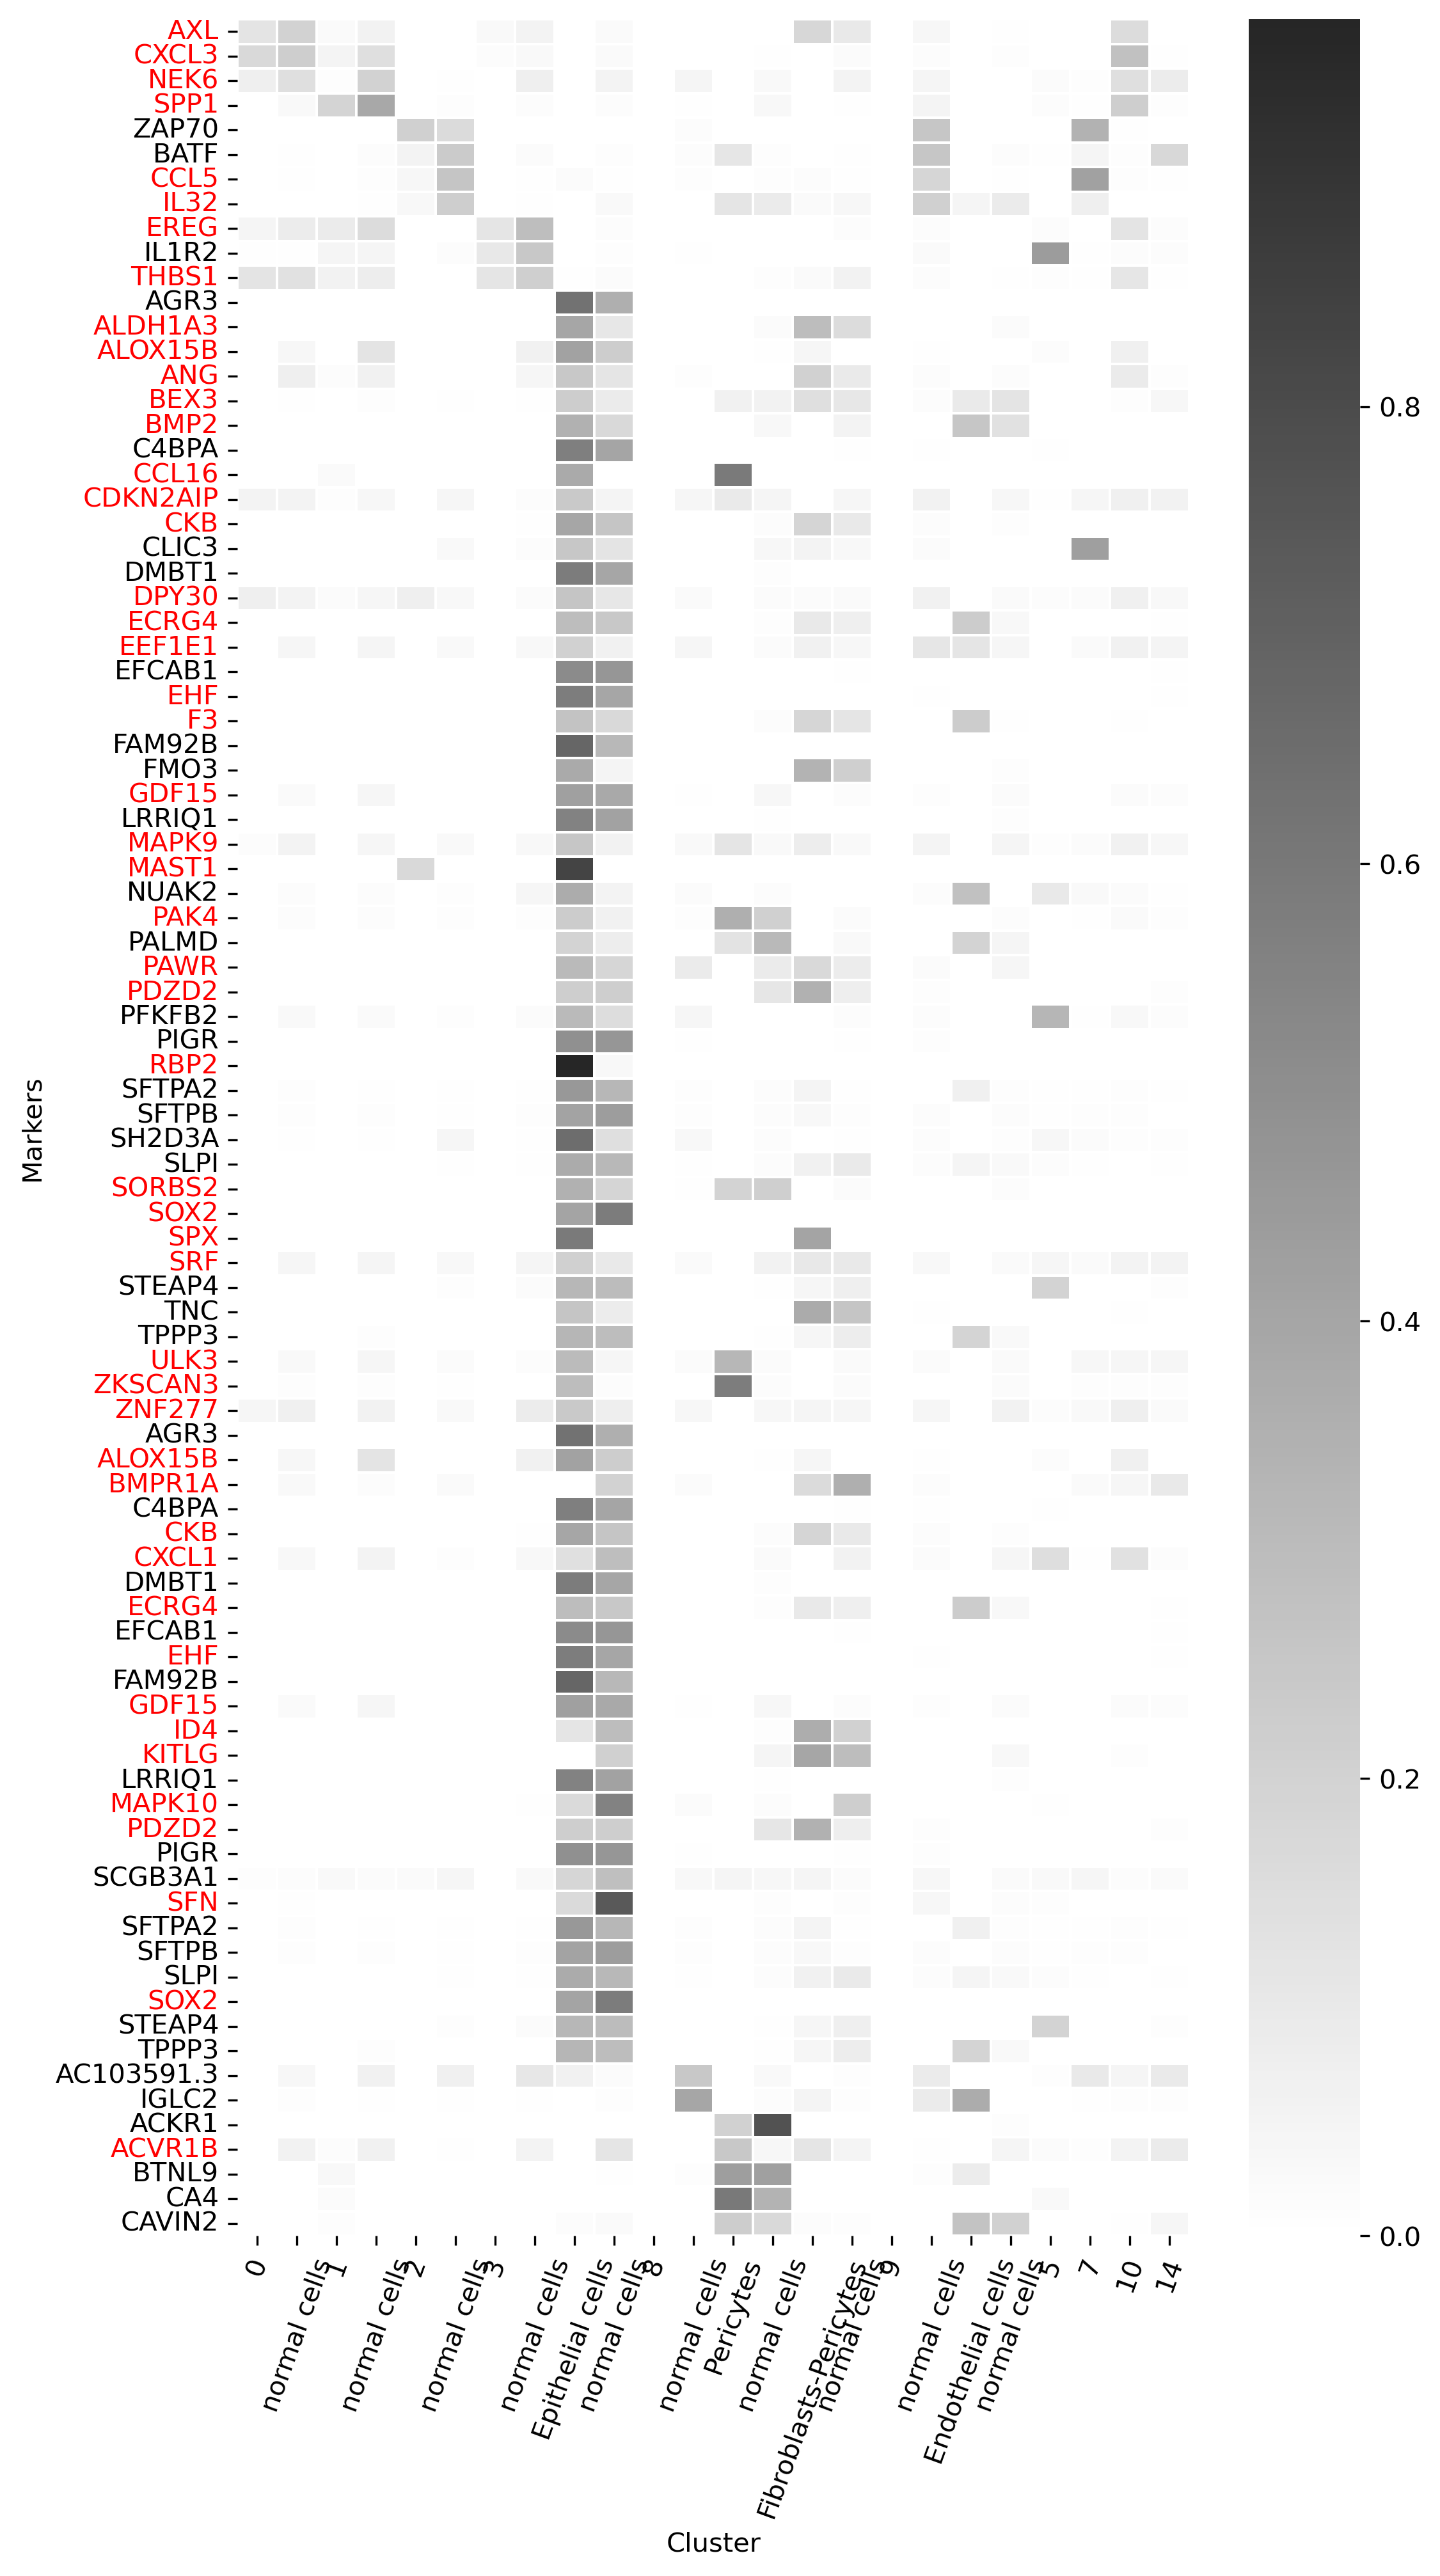

In [6]:
plt.figure(figsize=(8,15),dpi=300)

split=90
ax=sns.heatmap(matrix[:split,:], cmap=sns.dark_palette("white", reverse=True, as_cmap=True),xticklabels=cols_names,yticklabels=rows[:split],linewidth=.5)
plt.ylabel('Markers')
plt.xlabel("Cluster")
# plt.get_ticklines()
for tick in ax.get_xticklabels():
    tick.set_rotation(70)
for i in indexs:
    if i<split:
        ax.get_yticklabels()[i].set_color("red") 

# 2022-11-30 21:18:56.532 [DEBUG] [colorbar.py:620] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b7ccc9828e0>
# 2022-11-30 21:18:56.533 [DEBUG] [colorbar.py:665] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x2b7ccc9828e0> on colorbar
# 2022-11-30 21:18:56.534 [DEBUG] [colorbar.py:794] Setting pcolormesh


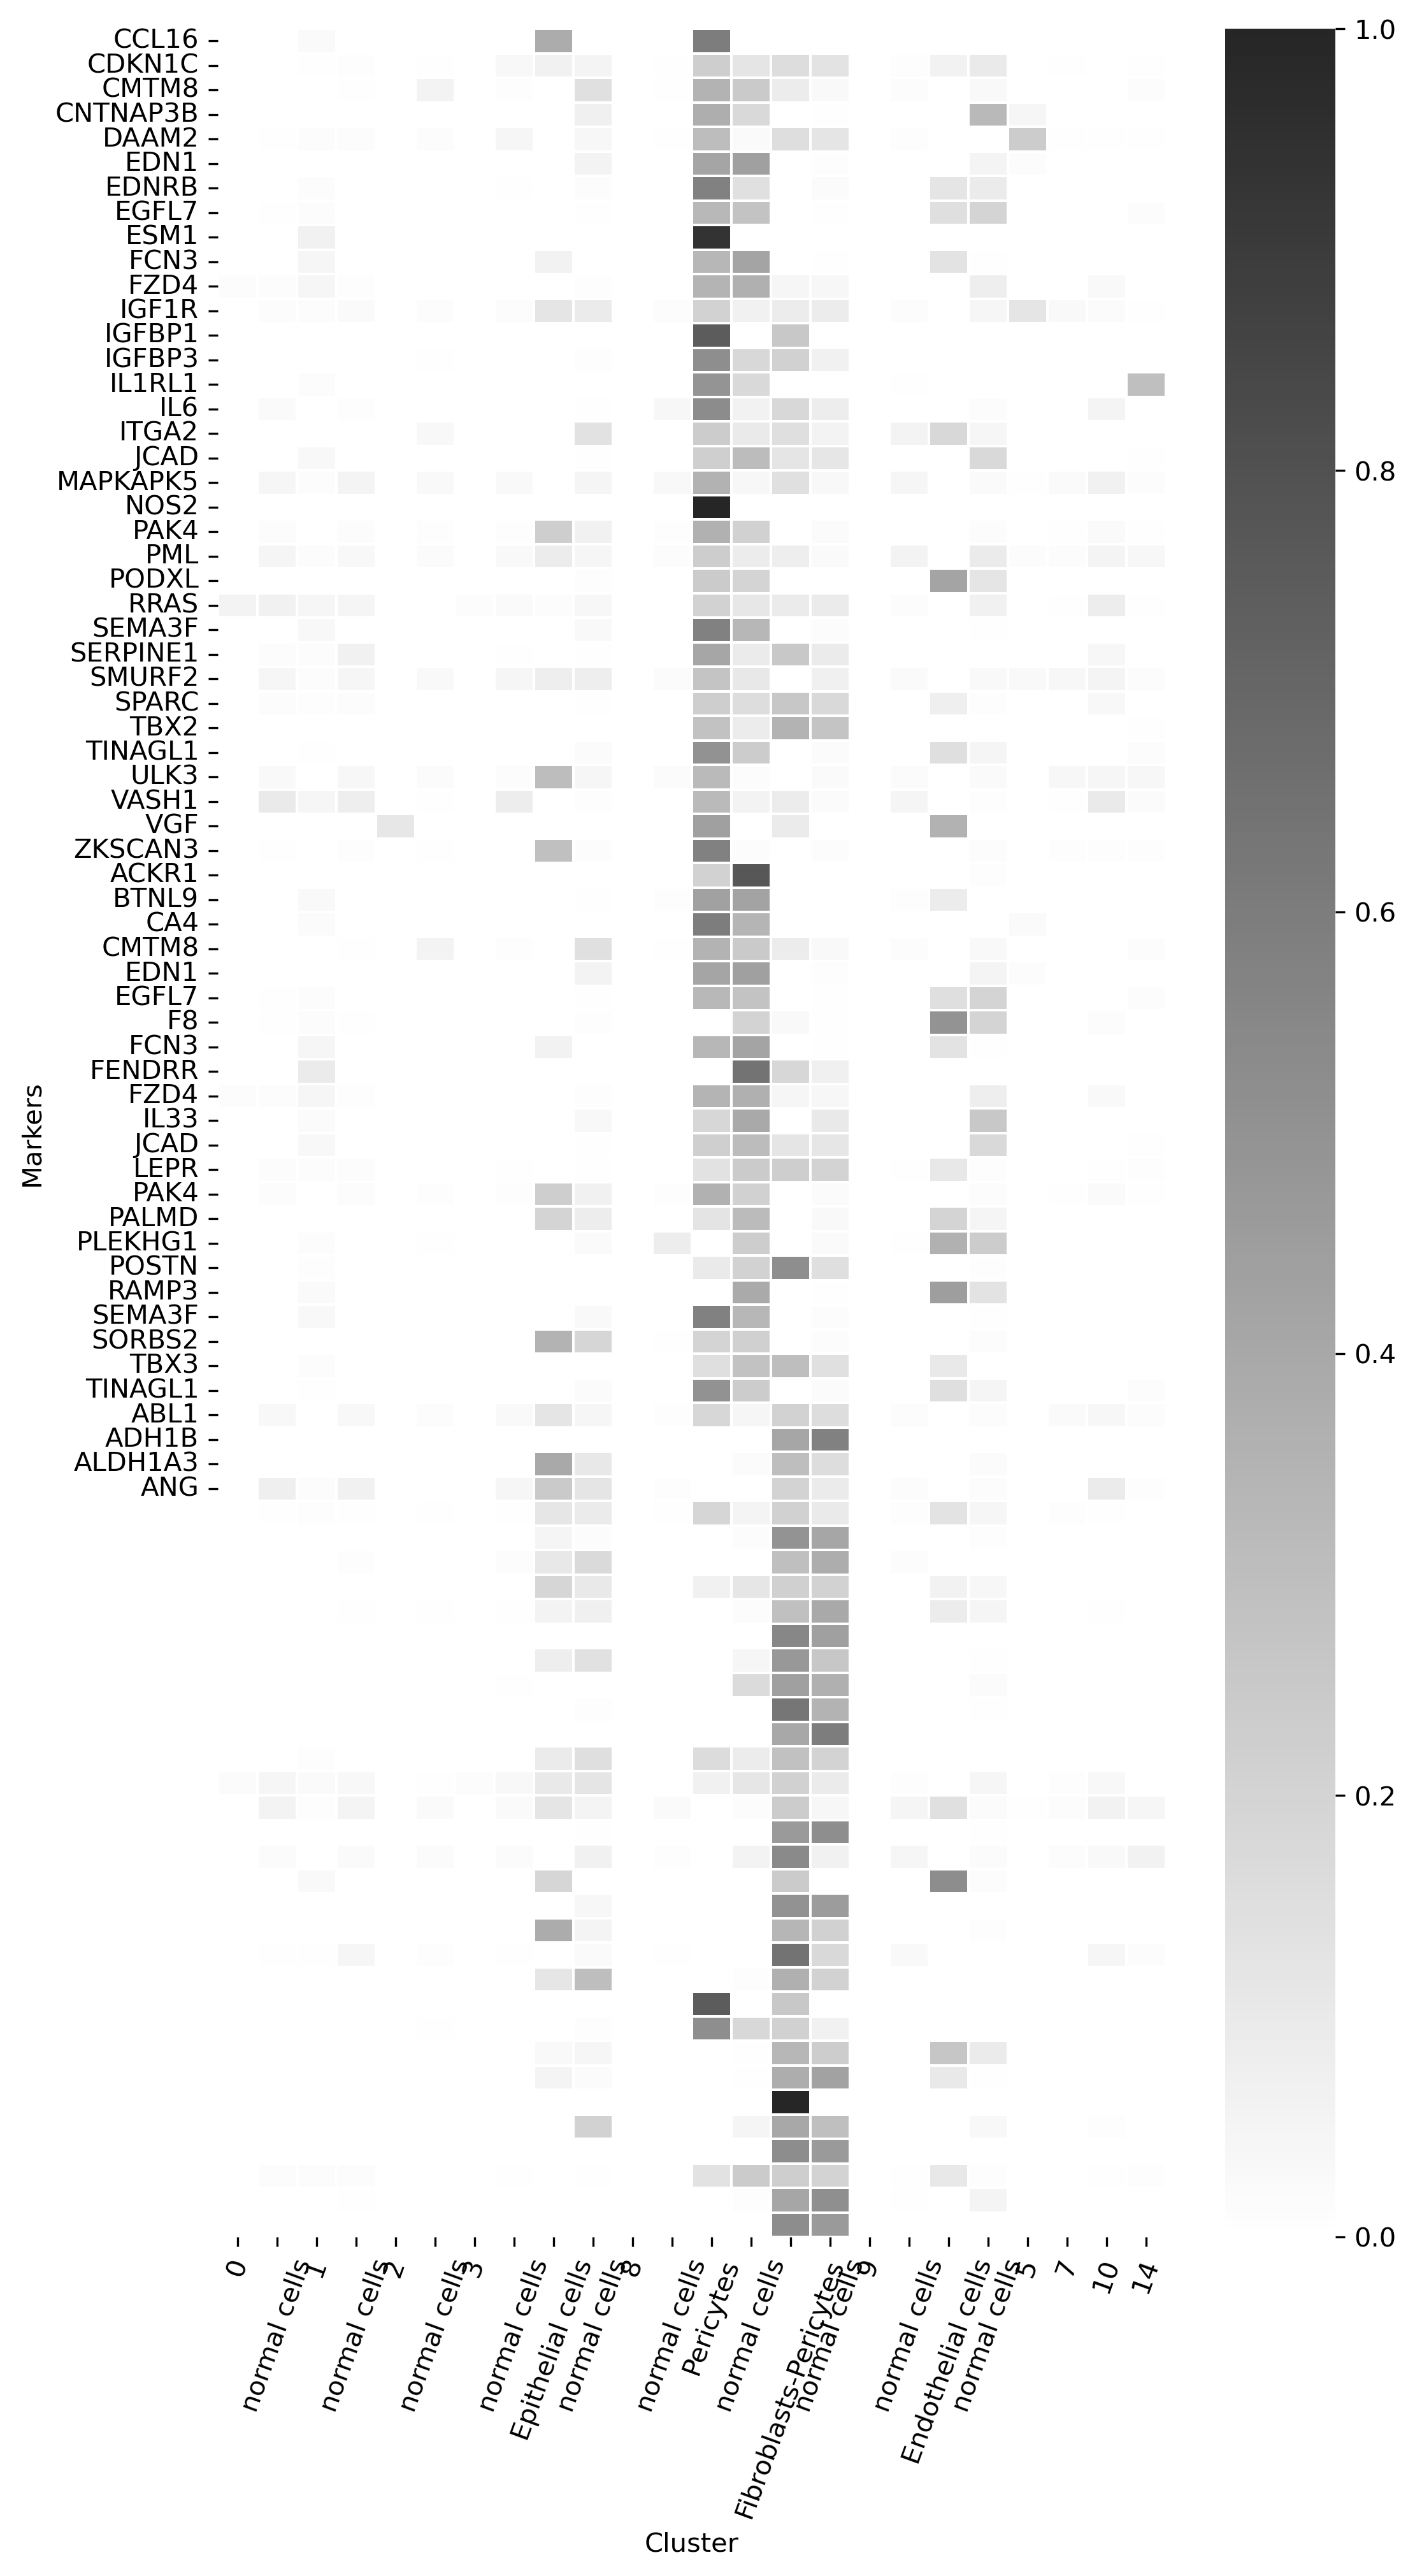

In [11]:
plt.figure(figsize=(8,15),dpi=300)

split=90
ax=sns.heatmap(matrix[90:180,:], cmap=sns.dark_palette("white", reverse=True, as_cmap=True),xticklabels=cols_names,yticklabels=rows[90:150],linewidth=.5)
plt.ylabel('Markers')
plt.xlabel("Cluster")
# plt.get_ticklines()
for tick in ax.get_xticklabels():
    tick.set_rotation(70)
# for i in indexs:
#     if i<100:
#         ax.get_yticklabels()[i].set_color("red") 

# 2022-11-30 21:14:29.699 [DEBUG] [font_manager.py:1329] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=5.0.
# 2022-11-30 21:14:29.701 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 21:14:29.702 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 21:14:29.702 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
# 2022-11-30 21:14:29.703 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
# 2022-11-30 21:14:29.704 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
# 2022-11-30 21:14:29.705 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaV

# 2022-11-30 21:14:29.739 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 21:14:29.739 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed.ttf) normal normal 400 condensed>) = 10.25
# 2022-11-30 21:14:29.740 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 21:14:29.740 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
# 2022-11-30 21:14:29.741 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 21:14:29.742 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 1.25
# 2022-11-30 21:14:29.742 [DEBUG] [font_manager.py:1

# 2022-11-30 21:14:29.781 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu LGC Sans Mono' (DejaVuLGCSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
# 2022-11-30 21:14:29.782 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
# 2022-11-30 21:14:29.782 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
# 2022-11-30 21:14:29.783 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIX' (STIX-Bold.otf) normal normal 700 normal>) = 10.335
# 2022-11-30 21:14:29.783 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIX' (STIX-Italic.otf) italic normal 400 normal>) = 11.05
# 2022-11-30 21:14:29.784 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'Padauk' (Padauk.ttf) normal normal 400 normal>) = 10.05
# 2022-11-30 21:14:29.784 [DEBUG] [font_manager.py:1341] findfont: score(<Font 'STIX Math' (STIXMath-Regular.otf) normal

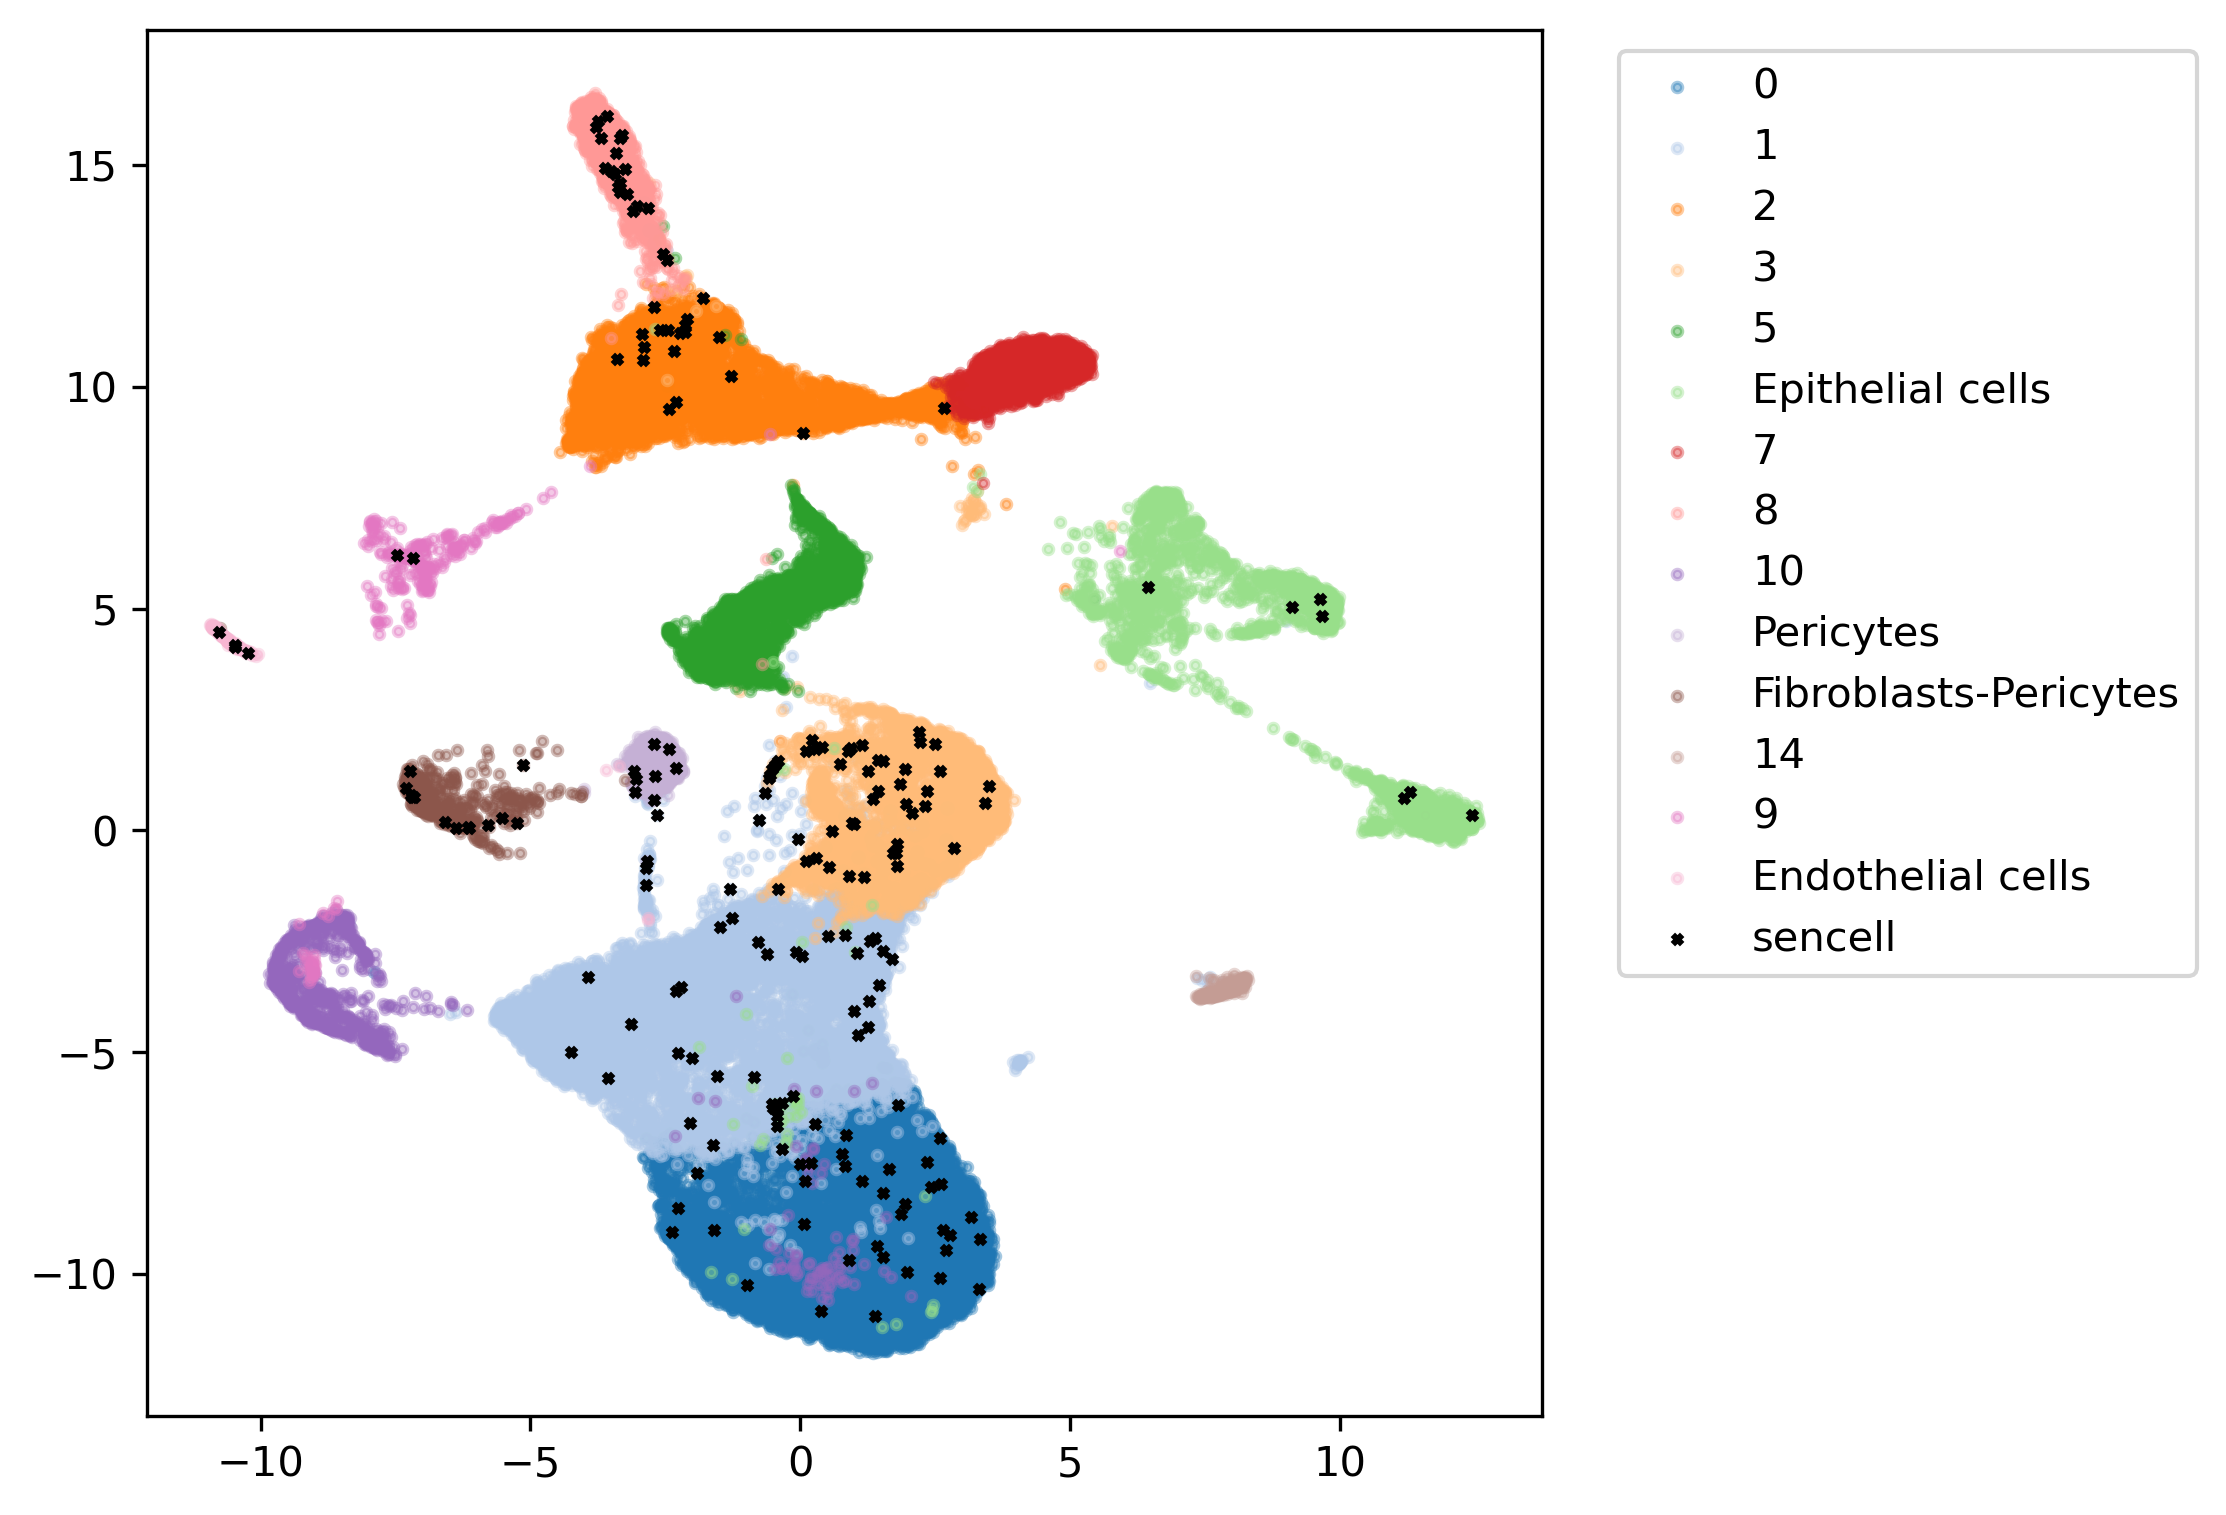

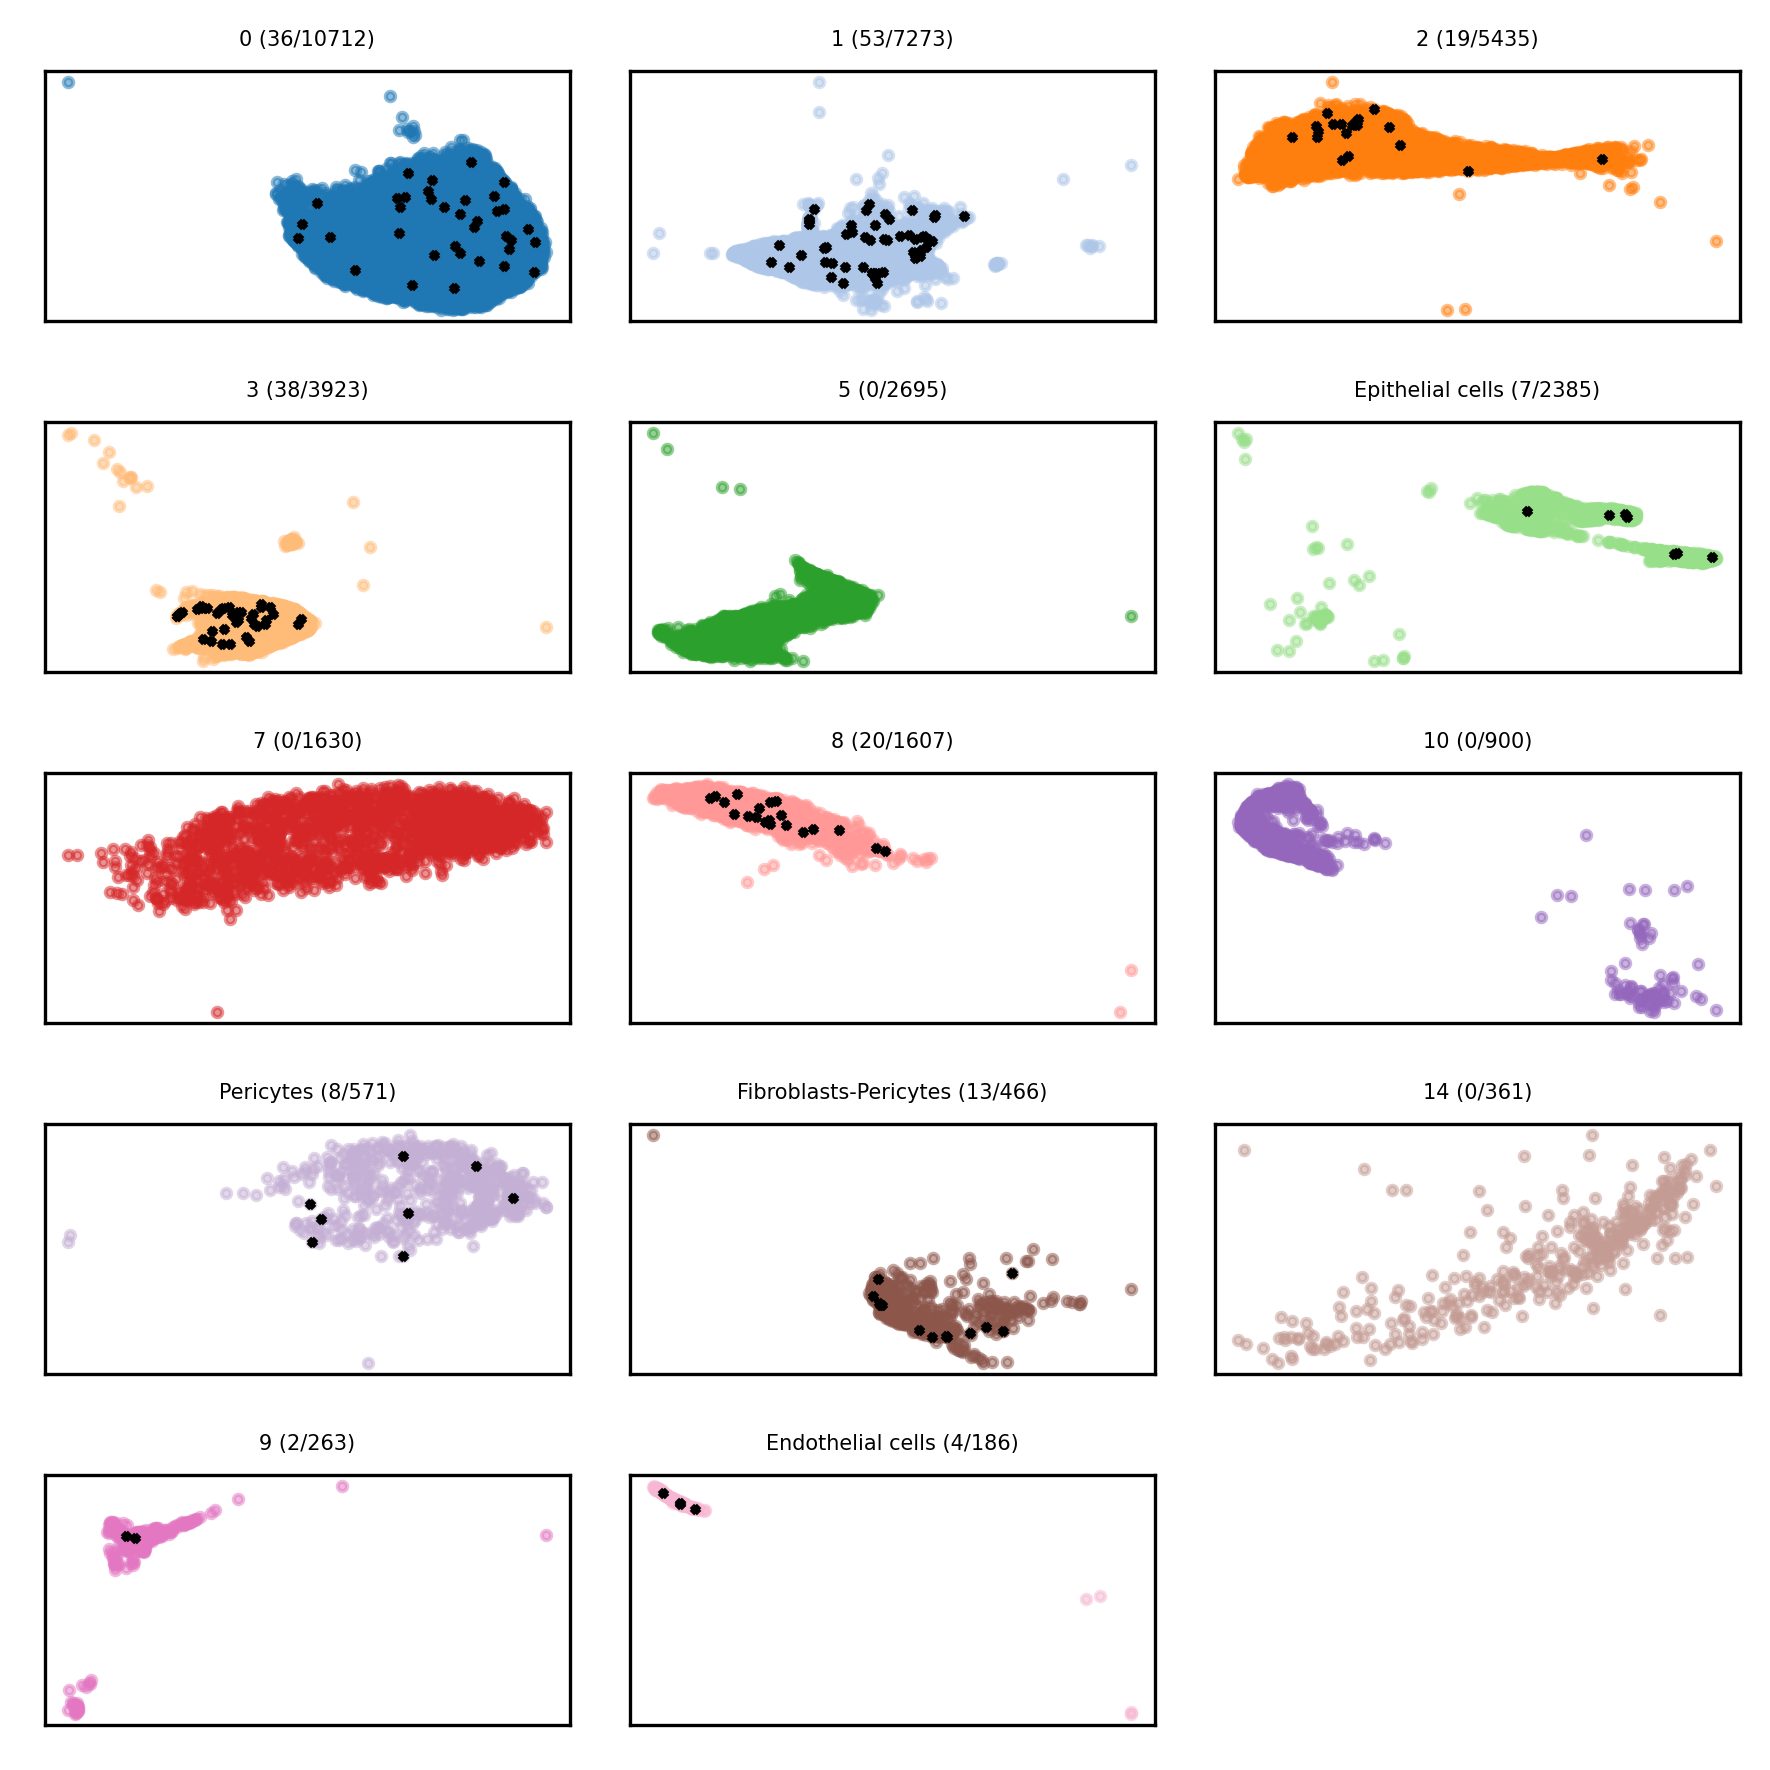

In [7]:
def umapPlot(embedding,cell_index_ls,clusters=None,reduce=False,labels=None):
    # if tensor: embedding should be .cpu().detach()
    # clusters: Nxt
    # t里面存的是行的index
    if reduce:
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(embedding)
    
    plt.figure(figsize=(6,6),dpi=300)
    cmap1 = matplotlib.cm.get_cmap('tab20')        
    cmap2 = matplotlib.cm.get_cmap('Set3')  
    color_ls=cmap1.colors+cmap2.colors
    if clusters is None:
        plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
    else:
        for i,(cluster,label) in enumerate(zip(clusters,labels)):
            plt.scatter(embedding[cluster,0],embedding[cluster,1],alpha=0.4,s=5,color=color_ls[i],label=label)
            
        plt.scatter(embedding[cell_index_ls,0],embedding[cell_index_ls,1],s=5,color='black',marker='x',label='sencell')
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

def subUmapPlot(embedding,clusters=None,reduce=False,labels=None):
    # if tensor: embedding should be .cpu().detach()
    # clusters: Nxt
    # t里面存的是行的index
    if reduce:
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(embedding)
    
    fig, axes = plt.subplots(5, 3, sharex=False, sharey=False,figsize=(6,6),dpi=300)

    cmap1 = matplotlib.cm.get_cmap('tab20')        
    cmap2 = matplotlib.cm.get_cmap('Set3')  
    color_ls=cmap1.colors+cmap2.colors
    if clusters is None:
        plt.scatter(embedding[:,0],embedding[:,1],alpha=0.5,s=5)
    else:
        x_s=[]
        y_s=[]
        label_s=[]
        for cluster,label in zip(clusters,labels):
            x_s.append(embedding[cluster,0])
            y_s.append(embedding[cluster,1])
            label_s.append(label)
        count=0
        for i, row in enumerate(axes):
            for j, col in enumerate(row):
                if count<14:
                    col.scatter(x_s[count],y_s[count],alpha=0.5,color=color_ls[count],s=5)
                    sencell_num=0
                    if count in cluster_cell_dict:
                        # 这一簇有老化细胞
                        col.scatter(embedding[cluster_cell_dict[count],0],embedding[cluster_cell_dict[count],1],
                                   s=3,color='black',marker='x',label='sencell')
                        sencell_num=len(cluster_cell_dict[count])
                        
                    col.set_title(f"{label_s[count]} ({sencell_num}/{len(clusters[count])})",fontsize=5)
                    count+=1
                else:
                    col.set_visible(False)
    plt.setp(fig.axes, yticks=[],xticks=[])
    
    plt.tight_layout()

        
umapPlot(adata.obsm['X_umap'],np.array(cell_index_ls),clusters=cluster_cell_ls,labels=celltype_names)
subUmapPlot(adata.obsm['X_umap'],clusters=cluster_cell_ls,labels=celltype_names)